[ 0.03647158 -0.06821286 -0.06679632]
[-0.03647158 -0.06679632 -0.06821286]


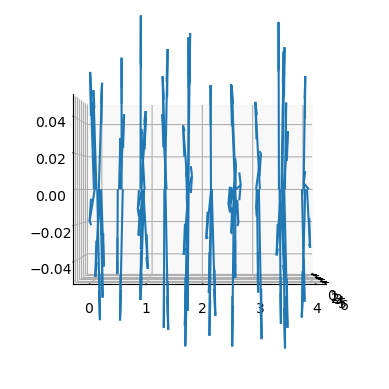

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 18 14:07:27 2025

@author: sylvestre.gay
"""


import plotly.graph_objects as go

import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R

class Configuration:
    #"""generate a configuration of spins"""
    
    def __init__(self, a,theta,Nx,Ny, J,T):
        #'we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins , '
        self.a,self.theta,self.Nx,self.Ny,self.J,self.T=a,theta,Nx,Ny,J,T
        self.N=Nx*Ny

        # a_1 and a_2 are the lattice translation generating vectors 
        a_1=a*np.array([1,0])
        a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])
        
        # we construct the unit cell
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        # then we create a random spin configuration  self.config as a unit 3d vector on each grid point
        #np.random.seed(50) #seed control for test
        
        config = 2*np.random.rand(dim[0],dim[1],dim[2],3) - 1.0
        norms = np.linalg.norm(config, axis=3, keepdims=True)    # shape (...,1)
        self.config = config / norms
        #print(self.config)



    def get_energy(self,sublattice):
        """this part implements the sommation over spins in a triangle(sublattice)"""
        
        S_sum = sublattice[0] + sublattice[1] + sublattice[2]
        E = 0.5 * self.J * np.dot(S_sum, S_sum)
        return E

    def total_energy(self):
        """ this part implements the summation of energy over the whole lattice"""

        E=0
        for i in range(self.Nx):
            for j in range(self.Ny):
                # we have for each triangle up self.config[i,j,:,:] 
                # the triangle down formed from the sites 
                im = (i-1) % self.Nx
                jm = (j-1) % self.Ny
                Triangle_down = [(i, j, 0), (i, jm, 1), (im, j, 2)]

                # we use the get eneergy function on each triangles for all the lattice
                E=E+self.get_energy(self.config[i,j,:,:])+self.get_energy(self.config[Triangle_down])
        
        return E


    def delta_energy(self,x_i,y_i,s_i):
        ''' this function is used to compute the energy difference for a flip '''

        # we get the new spin configuration
        newconf=self.newconf
        # Just as before we compute the coordinates of the two sublattices (triangles) affected by this modification
        kernel=[[[x_i,y_i-1,1],[x_i-1,y_i,2]],[[x_i-1,y_i+1,2],[x_i,y_i+1,0]],[[x_i+1,y_i-1,1],[x_i+1,y_i,0]]]
        Triangle_up=[[x_i,y_i,0],[x_i,y_i,1],[x_i,y_i,2]]
        Triangle_down=np.mod([[x_i,y_i,s_i]]+kernel[s_i],[self.Nx,self.Ny,3])

        #the energy differnece between the new config (self.newconf) and the old one (self.conf) is computed 
        Delta_E= self.get_energy(newconf[Triangle_up])+self.get_energy(newconf[Triangle_down])-self.get_energy(self.config[Triangle_up])-self.get_energy(self.config[Triangle_down])


        return Delta_E




    def Monte_Carlo(self,Nf,overrelaxation=False,ecart_type=0.01):
        '''In this part we implement the Nf monte carlo steps
        here with the metropolis move'''


        # this code will select a number Nf of random 3d rotations 
        #all with the same probability over the sphere
        beta=1/self.T
        q = normal(size=(Nf,4))
        q /= np.linalg.norm(q) 
        r = R.from_quat(q)

        # if we want to use the overrelaxation 
        #this code will select a number Nf of random 3d rotations 
        #with a gaussian distribution around identity
        if overrelaxation==True:
            q =normal(scale=[1,ecart_type,ecart_type,ecart_type],size=(4))
            q = normal(size=(Nf,4))
            q /= np.linalg.norm(q) 
            r = R.from_quat(q)

        # we select the number Nf of sites that could be flipped
        flips=np.random.randint([0,0,0],[self.Nx-1,self.Ny-1,2],size=(Nf,3))

        # we initialize a copy of the current spin configuration named self.newconf
        self.newconf=self.config.copy()
        
        #this flag is an integer to count the number of flips that are validated 
        # to keep track of the rejection  rate
        flag=0

        for num,pick in enumerate(flips):
            # we  we rotate a spin of the new configuration 

            self.newconf[pick[0],pick[1],pick[2],:]= r[num].apply( self.config[pick[0],pick[1],pick[2],:] ) 

            # we renormalise this spin after rotation because matrix 
            # multiplication errors can denormalise a little bit after a rotation our unit vectors
            Norm = np.linalg.norm(self.newconf[pick[0], pick[1], pick[2], :])
            self.newconf[pick[0], pick[1], pick[2], :] /= Norm

            # energy difference calculations
            delta= self.delta_energy(pick[0],pick[1],pick[2])

            # Metropolis move
            if rnd.random() < np.exp(-beta*delta):
                self.newconf = self.config.copy()
                flag+=1
            
        #print('Acceptance rate=',flag/Nf)


    def display_config(self):
    
        position = np.reshape(self.lattice, (3*self.Nx*self.Ny, 2), order='C')
        arrows   = np.reshape(self.config,  (3*self.Nx*self.Ny, 3), order='C')
    
        # Positions of the points of the lattice on the plane z=0
        x = position[:, 0]
        y = position[:, 1]
        z = np.zeros(3*self.Nx*self.Ny)
    
        # Directions of spin Sx, Sy, Sz
        Sx = arrows[:, 0]
        Sy = arrows[:, 1]
        Sz = arrows[:, 2]
    
        # Building the segments representing the spins. At a point (x,y,0), the segment goes to (x+u,y+v,w)
        
        X_lines = []
        Y_lines = []
        Z_lines = []
    
        for xi, yi, zi, Sxi, Syi, Szi in zip(x, y, z, Sx, Sy, Sz):
            X_lines += [xi, xi + Sxi, None] # None is here to separate the segments, otherwise they would be connected·  
            Y_lines += [yi, yi + Syi, None]
            Z_lines += [zi, zi + Szi, None]
    
    
    
        # Creation of Plotly figure
        fig = go.Figure()
    
        fig.add_trace(go.Scatter3d(
            x=X_lines, y=Y_lines, z=Z_lines,
            mode="lines",
            line=dict(width=3, color="blue"),
        ))
        
        fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode="markers",
        marker=dict(size=4, color="red"),
        name="Start points"
        ))
    
        # Axis
        fig.update_layout(
            title="Lattice + Vecteurs (interactive Plotly)",
            scene=dict(
                xaxis_title="x",
                yaxis_title="y",
                zaxis_title="z",
                aspectmode='data'
            ),
            width=2700,
            height=1100
            
        )
    
        # Show in browser
        fig.show(renderer="browser")



    def spin_realign(self):

        ax = plt.figure().add_subplot(projection='3d')

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')



        Avg=np.mean(arrows,axis=0)
        print(Avg)
        Avg/=np.linalg.norm(Avg)
        r = R.from_quat([0,1,1,0])
        arrows=r.apply(arrows,inverse=False)
        print(np.mean(arrows,axis=0))



        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]
        
        ax.quiver(x,y,z, u, v, w, length=0.1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=0, roll=0)
        plt.show()


    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('norm=',LA.norm(self.config,axis=0).max())


J=1
T=200
Nx=5
Ny=5
theta=2*np.pi/3
a=1
A=Configuration(1,theta,Nx,Ny,J,T)
A.display_config()
A.spin_realign()
A.Monte_Carlo(8000,overrelaxation=False)
#A.display_config()
